# Week 2 Project

**Students**: Sergio Casas Pastor, Sanket Biswas and Josep Brugués i Pujolràs

**TEST CODE**

In [1]:
from __future__ import print_function
import cv2
import numpy as np

try:
   import cPickle as pickle # Python 2
except:
   import pickle # Python 3

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer, PowerTransformer, MinMaxScaler
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

Let us first read the train and test files

In [2]:
try:
    train_images_filenames = pickle.load(open('train_images_filenames.dat','r'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','r'))
    train_labels = pickle.load(open('train_labels.dat','r'))
    test_labels = pickle.load(open('test_labels.dat','r'))
except:
    train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
    test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
    train_labels = pickle.load(open('train_labels.dat','rb'))
    test_labels = pickle.load(open('test_labels.dat','rb'))

In [3]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

In [4]:
train_labels[12]

'Opencountry'

We create a SIFT object detector and descriptor

In [5]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=900)
start = time.time()

We create a Normalizer

In [6]:
norm = "minmax" #Valid norms: l1, l2, max, power, minmax

if norm == "power":
    transformer = PowerTransformer() # Defaults to ’yeo-johnson’ method 
                                                 # (Not working with scikit 0.20.4 because of a bug)
elif norm == "minmax":
    transformer = MinMaxScaler() # Defaults to 0-1 range
else: # l1, l2 or max
    try:
        transformer = Normalizer(norm=norm)
    except:
        print("Invalid norm. Using L2 instead")
        transformer = Normalizer(norm="l2")

We compute different spatial pyramid level

In [7]:
level = 1
level = 2**(level-1)

We compute the SIFT descriptors for the all the train images and subsequently build a numpy array with all the descriptors stacked together

In [8]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    
    # Resize image
    scale_percent = 100 # percent of original size
    width = int(ima.shape[1] * scale_percent / 100)
    height = int(ima.shape[0] * scale_percent / 100)
    dim = (width, height)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA) 
    
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    step = 8 # Separation of pixels between keypoints
    descriptors = []

    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))   # Number of width pixels for sub-image
    
    for height in range(0, ima.shape[0], height_block):
        for width in range(0, ima.shape[1], width_block):
            block = gray[height:height + height_block, width:width + width_block]
            keypoints_block = []
        
            for i in range(int(step/2), block.shape[0], step):
                for j in range(int(step/2), block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(i, j, step))
     
            _, descriptors_block = SIFTdetector.compute(block,keypoints_block)
            descriptors.extend(descriptors_block)
    
    Train_descriptors.append(descriptors)
    Train_label_per_descriptor.append(labels)

Train_descriptors = np.array(Train_descriptors)
nsamples, nx, ny = Train_descriptors.shape
Train_descriptors = Train_descriptors.reshape((nsamples,nx*ny))
#nsamples, nx = Train_descriptors.shape
Train_descriptors_scaled = transformer.fit_transform(Train_descriptors)
Train_descriptors_scaled = Train_descriptors_scaled.reshape((nsamples, nx, ny))
D=np.vstack(Train_descriptors_scaled)

We now compute a k-means clustering on the descriptor space

In [9]:
k = 170
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=3400, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=170, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [10]:
visual_words=np.zeros((len(Train_descriptors_scaled),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors_scaled[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors. We use GridSearchCV to do Cross-Validation and find the best parameters of the k-nn classifier.

Parameters set found on development set:


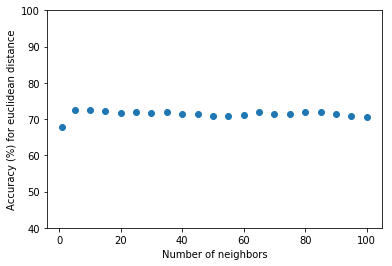

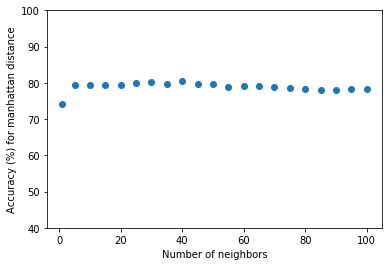

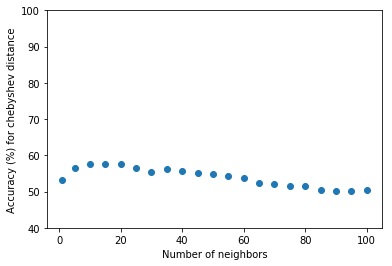

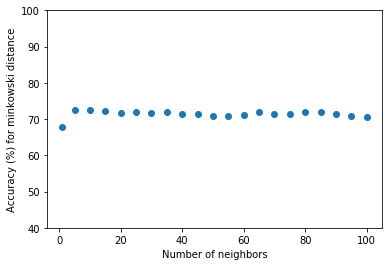

Maximum accuracy for validation set is 80.38277511961722 with n_neighbors = 40 and metric = manhattan


In [11]:
# Find best parameters
parameters = {'n_neighbors':[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], \
              'metric':['euclidean','manhattan','chebyshev','minkowski']}
knn = KNeighborsClassifier(n_jobs=-1)
clf = GridSearchCV(knn, parameters, cv=5) # StratifiedKFold n_splits = 5
clf.fit(visual_words, train_labels) 

print("Parameters set found on development set:")
means = 100 * clf.cv_results_['mean_test_score']

# Train again with best parameters
knn_best = KNeighborsClassifier(n_neighbors= clf.best_params_['n_neighbors'],n_jobs=-1,metric=clf.best_params_['metric'])
knn_best.fit(visual_words, train_labels)

plt.scatter(parameters['n_neighbors'], means[0:21])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for euclidean distance")
plt.ylim((40,100))
plt.show()

plt.scatter(parameters['n_neighbors'], means[21:42])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for manhattan distance")
plt.ylim((40,100))
plt.show()

plt.scatter(parameters['n_neighbors'], means[42:63])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for chebyshev distance")
plt.ylim((40,100))
plt.show()

plt.scatter(parameters['n_neighbors'], means[63:84])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%) for minkowski distance")
plt.ylim((40,100))
plt.show()

print ("Maximum accuracy for validation set is", max(means), "with n_neighbors =", clf.best_params_['n_neighbors'], "and metric =",  clf.best_params_['metric']) 


We end up computing the test descriptors and compute the accuracy of the model

In [12]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
Test_descriptors = []
for image in range(len(test_images_filenames)):
    filename=test_images_filenames[image]
    ima=cv2.imread(filename)
    
    # Resize image
    width = int(ima.shape[1] * scale_percent / 100)
    height = int(ima.shape[0] * scale_percent / 100)
    dim = (width, height)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA) 
    
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            
    descriptors = []

    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))    # Number of width pixels for sub-image
    for height in range(0, ima.shape[0], height_block):
        for width in range(0, ima.shape[1], width_block):
            block = gray[height:height + height_block, width:width + width_block]
            keypoints_block = []
    
            for i in range(int(step/2), block.shape[0], step):
                for j in range(int(step/2), block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(i, j, step))
            
            _, descriptors_block = SIFTdetector.compute(block,keypoints_block)   
            descriptors.extend(descriptors_block)
    
    Test_descriptors.append(descriptors)
    
Test_descriptors = np.array(Test_descriptors)
nsamples, nx, ny = Test_descriptors.shape
Test_descriptors = Test_descriptors.reshape((nsamples, nx*ny))
Test_descriptors_scaled = transformer.transform(Test_descriptors)
Test_descriptors_scaled = Test_descriptors_scaled.reshape((nsamples, nx, ny))

for image in range(len(test_images_filenames)):
    words=codebook.predict(Test_descriptors_scaled[image])
    visual_words_test[image,:]=np.bincount(words,minlength=k) 

Compute the accuracy of the model

In [13]:
accuracy = 100*knn_best.score(visual_words_test, test_labels)
print(accuracy)
end = time.time()
print(end - start)

79.80173482032218
357.887979984


Dimensionality reduction, with PCA and LDA. Following the example just seen before, we can also do Cross-Validation:

In [14]:
# Principal Component Analysis
pca = PCA(n_components=None)
VWpca = pca.fit_transform(visual_words)

# Find best parameters
knnpca = KNeighborsClassifier(n_jobs=-1)
clfpca = GridSearchCV(knnpca, parameters, cv=5) # StratifiedKFold n_splits = 5
clfpca.fit(VWpca, train_labels) 
meanspca = 100 * clfpca.cv_results_['mean_test_score']
print ("Maximum accuracy for validation set is", max(meanspca), "with n_neighbors =", clfpca.best_params_['n_neighbors'], "and metric =",  clfpca.best_params_['metric']) 

# Train again with best parameters
knnpca_best = KNeighborsClassifier(n_neighbors= clfpca.best_params_['n_neighbors'],n_jobs=-1,metric=clfpca.best_params_['metric'])
knnpca_best.fit(VWpca, train_labels) 

vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca_best.score(vwtestpca, test_labels)
print(accuracy)


# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=None)
VWlda = lda.fit_transform(visual_words,train_labels)

# Find best parameters
knnlda = KNeighborsClassifier(n_jobs=-1)
clflda = GridSearchCV(knnlda, parameters, cv=5) # StratifiedKFold n_splits = 5
clflda.fit(VWlda, train_labels) 
meanslda = 100 * clflda.cv_results_['mean_test_score']
print ("Maximum accuracy for validation set is", max(meanslda), "with n_neighbors =", clflda.best_params_['n_neighbors'], "and metric =",  clflda.best_params_['metric']) 

# Train again with best parameters
knnlda_best = KNeighborsClassifier(n_neighbors= clflda.best_params_['n_neighbors'],n_jobs=-1,metric=clflda.best_params_['metric'])
knnlda_best.fit(VWlda, train_labels) 

vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda_best.score(vwtestlda, test_labels)
print(accuracy)

Maximum accuracy for validation set is 72.62094630515683 with n_neighbors = 5 and metric = euclidean
75.58859975216853


/home/josep/Documents/Python/venv27/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/josep/Documents/Python/venv27/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Maximum accuracy for validation set is 88.99521531100478 with n_neighbors = 30 and metric = euclidean
83.14745972738538


**RESULTS AND DISCUSSION**

We first implemented Dense SIFT. Compared to last weeks's results, 
we improved around 10-15%, depending on dimensionality reduction and other factors.
Then, we analysed the behaviour of Dense SIFT when changing the number of pixels between keypoints.
The results can be seen in the following graphic:

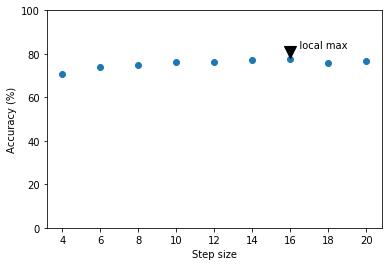

Local max is 77.69 % accuracy at step= 16


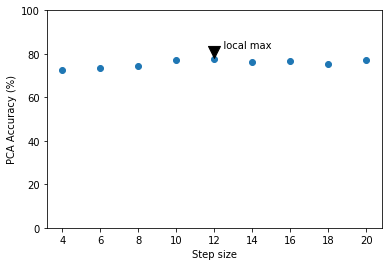

Local max is 77.69 % PCA accuracy at step= 12


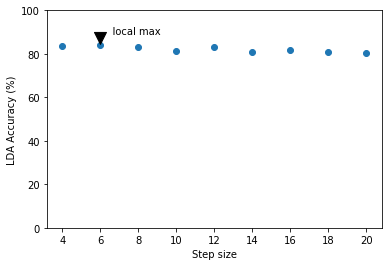

Local max is 84.13 % LDA accuracy at step= 6


In [15]:
step = [4,6,8,10,12,14,16,18,20]
accuracy = [70.63,74.10,75.09,76.08,76.08,77.32,77.69,75.58,76.70]
lda_accuracy = [83.39,84.13,83.27,81.16,83.27,81.04,81.9,80.79,80.17]
pca_accuracy = [72.49,73.60,74.34,77.32,77.69,76.08,76.70,75.24,77.19]

# Accuracy
plt.scatter(step, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% accuracy at step=",xmax)
    

# Principal Component Analysis
plt.scatter(step, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% PCA accuracy at step=",xmax)

    
# Linear Discriminant Analysis
plt.scatter(step, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = step[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print("Local max is", ymax,"% LDA accuracy at step=",xmax)

We have decided that a step of 8 pixels is the best one, as it accomplishes
one of the best LDA accuracies while not taking much time to complete the computations.

After that, we resized the images to new scales to see if the performance 
could be further improved:

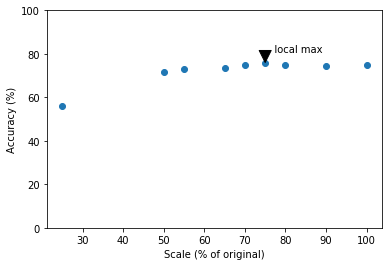

Local max is 75.83 % accuracy at scale= 75


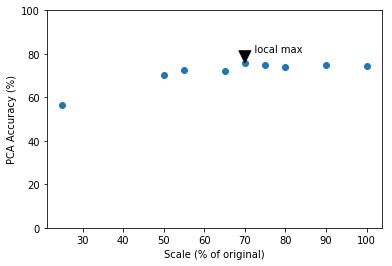

Local max is 75.71 % PCA accuracy at scale= 70


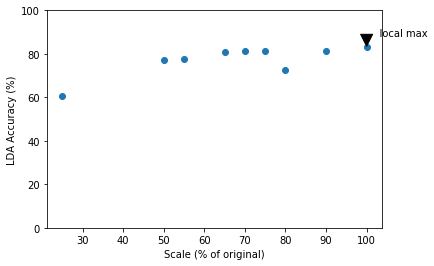

Local max is 83.27 % LDA accuracy at scale= 100


In [16]:
scale = [100,90,80,75,70,65,55,50,25]
accuracy = [75.09,74.47,74.72,75.83,75.09,73.60,72.86,71.49,55.88]
lda_accuracy = [83.27,81.53,72.42,81.53,81.53,80.66,77.57,77.32,60.47]
pca_accuracy = [74.34,74.71,74.10,74.84,75.71,72.24,72.49,70.38,56.50]

# Accuracy
plt.scatter(scale, accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% accuracy at scale=",xmax)

    
# Principal Component Analysis
plt.scatter(scale, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% PCA accuracy at scale=",xmax)
    
    
# Linear Discriminant Analysis
plt.scatter(scale, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Scale (% of original)")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = scale[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print("Local max is", ymax,"% LDA accuracy at scale=",xmax)



As it can be seen from before, the best results are accomplished when the image
is not resized (we take into account the highest accuracy, LDA at scale 100%).



We implement different levels of spatial pyramids. Each level represents one subdivision of the image and for each division, we calculate dense SIFT descriptors. Then, we concatenate the descriptors of each block image and we use KNeighborsClassifier. We evaluate spatial pyramids using different dense SIFT steps and using cross validation.

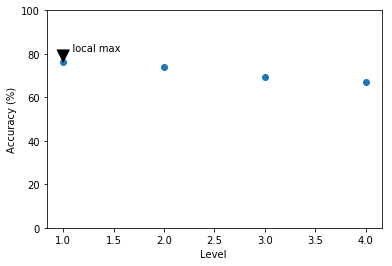

Local max is 76.08 % accuracy at level= 1 with Dense SIFT step = 10


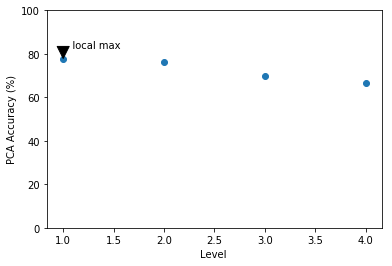

Local max is 77.69 % PCA accuracy at level= 1 with Dense SIFT step = 10


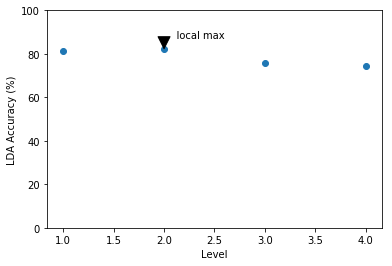

Local max is 82.16 % LDA accuracy at level= 2 with Dense SIFT step = 10


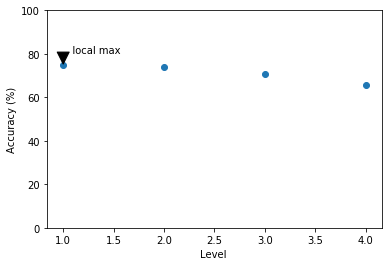

Local max is 75.09 % accuracy at level= 1 with Dense SIFT step = 8


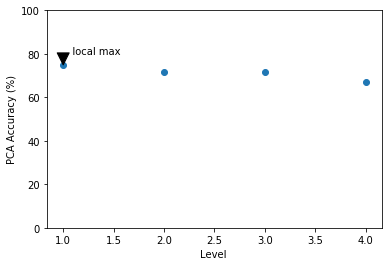

Local max is 74.72 % PCA accuracy at level= 1 with Dense SIFT step = 8


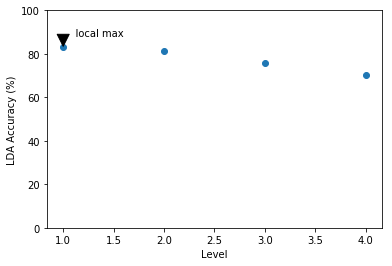

Local max is 83.27 % LDA accuracy at level= 1 with Dense SIFT step = 8


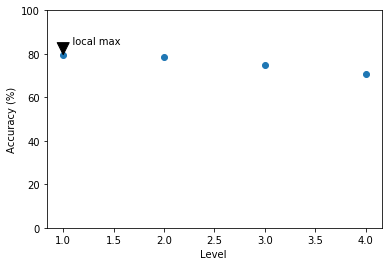

Local max is 79.43 % accuracy at level= 1 with Dense SIFT step = 8 and cross-validation


In [17]:
# Dense sift STEP = 10
level = [1, 2, 3, 4]
accuracy = [76.08, 74.1, 69.27, 67.16]
pca_accuracy = [77.69, 76.46, 70.01, 66.54]
lda_accuracy = [81.16, 82.16, 75.84, 74.47]

# Accuracy
plt.scatter(level, accuracy)
plt.ylim((0, 100))
plt.xlabel("Level ")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = level[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% accuracy at level=",xmax, "with Dense SIFT step = 10")

    
# Principal Component Analysis
plt.scatter(level, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Level ")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = level[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% PCA accuracy at level=",xmax, "with Dense SIFT step = 10")
    
    
# Linear Discriminant Analysis
plt.scatter(level, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Level")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = level[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% LDA accuracy at level=",xmax, "with Dense SIFT step = 10")

# Dense sift STEP = 8
accuracy = [75.09, 73.8, 70.87, 65.79]
pca_accuracy = [74.72, 71.87, 71.74, 66.91]
lda_accuracy = [83.27, 81.28, 75.71, 70.38]

# Accuracy
plt.scatter(level, accuracy)
plt.ylim((0, 100))
plt.xlabel("Level ")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = level[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% accuracy at level=",xmax, "with Dense SIFT step = 8")

    
# Principal Component Analysis
plt.scatter(level, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Level ")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = level[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% PCA accuracy at level=",xmax, "with Dense SIFT step = 8")
    
    
# Linear Discriminant Analysis
plt.scatter(level, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Level")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = level[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print("Local max is", ymax,"% LDA accuracy at level=",xmax, "with Dense SIFT step = 8")

# Dense sift STEP = 8, using cross-validatiion
accuracy = [79.43, 78.56, 75.09, 70.75]

# Accuracy
plt.scatter(level, accuracy)
plt.ylim((0, 100))
plt.xlabel("Level ")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = level[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% accuracy at level=",xmax, "with Dense SIFT step = 8 and cross-validation")


As we observe, spatial pyramids for Dense SIFT descriptors and KNeighborsClassifier do not help too much in the improvement of the accuracy. The majority of experiments show that level 1 is the best level (no division of the image).

Following the spatial pyramids, we implemented several methodologies for data normalization: L1-norm, L2-norm, MinMaxAbs norm and max norm. Due to a bug in the implementation in Scikit-Learn's library, power-norm could not be implemented.  


With normalisation, we also checked the difference between using or not using Cross-Validation to select the best parameters for the K-NN algorithm. The first 3 graphics show the accuracies without Cross-Validation, using the default parameters from before. The last 3 graphics show the accuracies with Cross-Validation, using the best parameters found by the Grid Search.

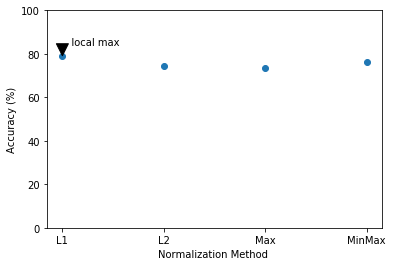

Local max is 78.93 % accuracy with= L1


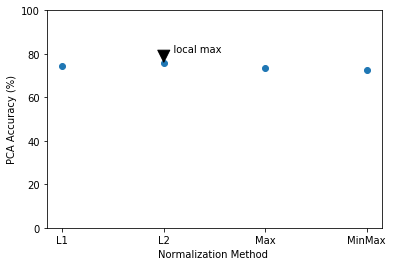

Local max is 75.96 % PCA accuracy with= L2


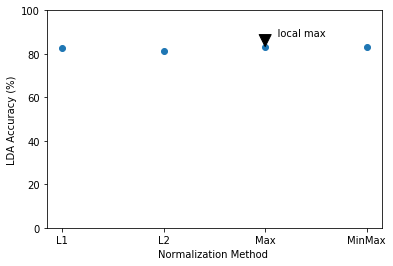

Local max is 83.14 % LDA accuracy with= Max


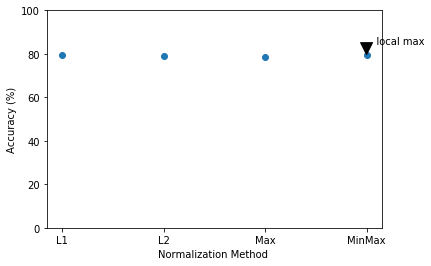

Local max is 79.42 % accuracy with= MinMax


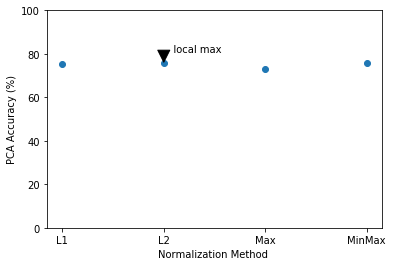

Local max is 75.96 % PCA accuracy with= L2


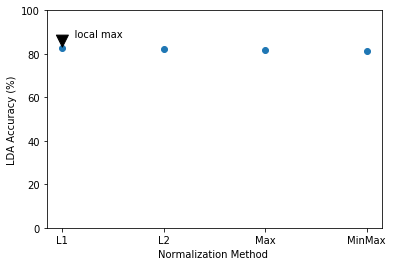

Local max is 82.89 % LDA accuracy with= L1


In [23]:
norms = ["L1","L2","Max","MinMax"]
accuracy = [78.93,74.47,73.72,76.20]
pca_accuracy = [74.47,75.96,73.72,72.72]
lda_accuracy = [82.89,81.53,83.14,83.14]

# NO CROSS-VALIDATION 
# Accuracy
plt.scatter(norms, accuracy)
plt.ylim((0, 100))
plt.xlabel("Normalization Method ")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = norms[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% accuracy with=",xmax)

    
# Principal Component Analysis
plt.scatter(norms, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Normalization Method ")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = norms[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% PCA accuracy with=",xmax)
    
    
# Linear Discriminant Analysis
plt.scatter(norms, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Normalization Method ")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = norms[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% LDA accuracy with=",xmax)


# WITH CROSS-VALIDATION
accuracy = [79.30,78.93,78.68,79.42]
pca_accuracy = [75.21,75.96,72.86,75.71]
lda_accuracy = [82.89,82.40,81.78,81.41]

# Accuracy
plt.scatter(norms, accuracy)
plt.ylim((0, 100))
plt.xlabel("Normalization Method ")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = norms[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% accuracy with=",xmax)

    
# Principal Component Analysis
plt.scatter(norms, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Normalization Method ")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = norms[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% PCA accuracy with=",xmax)
    
    
# Linear Discriminant Analysis
plt.scatter(norms, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Normalization Method ")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = norms[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print("Local max is", ymax,"% LDA accuracy with=",xmax)

As we can see from the plots, Cross-Validation helps improve the results in the Accuracy (without dimensionality reduction). When LDA or PCA is applied to the data, improvements when using Cross-Validation can only be seen with L1 and L2 normalization (with Max and MinMax, sometimes it improves and sometimes not).

Regarding the normalization process, we can see from the first 3 plots that the results are mixed when compared to the first results presented. The normal accuracy again is improved when doing data normalization, but when performing LDA and PCA the normalization does not improve the results.

**OPTIONAL - Fisher Vectors**

**OPTIONAL - Fisher Vectors**

We have used the fishervector library, developed by Jonas Rothfuss and Fabio Ferreira. More info: https://github.com/jonasrothfuss/fishervector

In [37]:
from scipy.stats import multivariate_normal
from sklearn import svm
import sys, glob

run_optional = True

if run_optional:
    def dictionary(descriptors, N):        
        em = cv2.ml.EM_create()
        em.setClustersNumber(N)
        em.trainEM(descriptors)

        return np.float32(em.getMeans()), \
            np.float32(em.getCovs()), np.float32(em.getWeights())[0]

    def image_descriptors(file):
        img = cv2.imread(file, 0)
        img = cv2.resize(img, (256, 256))
        sift = cv2.xfeatures2d.SIFT_create()
        _ , descriptors = sift.detectAndCompute(img, None)
        return descriptors

    def folder_descriptors(folder):
        files = glob.glob(folder + "/*.jpg")
        print("Calculating descriptors. Number of images is", len(files))
        return np.concatenate([image_descriptors(file) for file in files])


    def likelihood_moment(x, ytk, moment):
        x_moment = np.power(np.float32(x), moment) if moment > 0 else np.float32([1])
        return x_moment * ytk

    def likelihood_statistics(samples, means, covs, weights):
        gaussians, s0, s1,s2 = {}, {}, {}, {}
        samples = zip(range(0, len(samples)), samples)

        g = [multivariate_normal(mean=means[k], cov=covs[k]) for k in range(0, len(weights)) ]
        for index, x in samples:
            gaussians[index] = np.array([g_k.pdf(x) for g_k in g])

        for k in range(0, len(weights)):
            s0[k], s1[k], s2[k] = 0, 0, 0
            for index, x in samples:
                probabilities = np.multiply(gaussians[index], weights)
                probabilities = probabilities / np.sum(probabilities)
                s0[k] = s0[k] + likelihood_moment(x, probabilities[k], 0)
                s1[k] = s1[k] + likelihood_moment(x, probabilities[k], 1)
                s2[k] = s2[k] + likelihood_moment(x, probabilities[k], 2)

        return s0, s1, s2

    def fisher_vector_weights(s0, s1, s2, means, covs, w, T):
        return np.float32([((s0[k] - T * w[k]) / np.sqrt(w[k]) ) for k in range(0, len(w))])

    def fisher_vector_means(s0, s1, s2, means, sigma, w, T):
        return np.float32([(s1[k] - means[k] * s0[k]) / (np.sqrt(w[k] * sigma[k])) for k in range(0, len(w))])

    def fisher_vector_sigma(s0, s1, s2, means, sigma, w, T):
        return np.float32([(s2[k] - 2 * means[k]*s1[k]  + (means[k]*means[k] - sigma[k]) * s0[k]) / (np.sqrt(2*w[k])*sigma[k])  for k in range(0, len(w))])

    def normalize(fisher_vector):
        v = np.sqrt(abs(fisher_vector)) * np.sign(fisher_vector)
        return v / np.sqrt(np.dot(v, v))

    def fisher_vector(samples, means, covs, w):
        s0, s1, s2 =  likelihood_statistics(samples, means, covs, w)
        T = samples.shape[0]
        covs = np.float32([np.diagonal(covs[k]) for k in range(0, covs.shape[0])])
        a = fisher_vector_weights(s0, s1, s2, means, covs, w, T)
        b = fisher_vector_means(s0, s1, s2, means, covs, w, T)
        c = fisher_vector_sigma(s0, s1, s2, means, covs, w, T)
        fv = np.concatenate([np.concatenate(a), np.concatenate(b), np.concatenate(c)])
        fv = normalize(fv)
        return fv

    def generate_gmm(input_folder, N):
        words = np.concatenate([folder_descriptors(folder) for folder in glob.glob(input_folder + '/*')]) 
        print("Training GMM of size", N)
        means, covs, weights = dictionary(words, N)
        #Throw away gaussians with weights that are too small:
        th = 1.0 / N
        means = np.float32([m for k,m in zip(range(0, len(weights)), means) if weights[k] > th])
        covs = np.float32([m for k,m in zip(range(0, len(weights)), covs) if weights[k] > th])
        weights = np.float32([m for k,m in zip(range(0, len(weights)), weights) if weights[k] > th])

        np.save("means.gmm", means)
        np.save("covs.gmm", covs)
        np.save("weights.gmm", weights)
        return means, covs, weights

    def get_fisher_vectors_from_folder(folder, gmm):
        files = glob.glob(folder + "/*.jpg")
        return np.float32([fisher_vector(image_descriptors(file), *gmm) for file in files])

    def fisher_features(folder, gmm):
        folders = glob.glob(folder + "/*")
        features = {f : get_fisher_vectors_from_folder(f, gmm) for f in folders}
        return features

    def train(gmm, features):
        X = np.concatenate(features.values())
        Y = np.concatenate([np.float32([i]*len(v)) for i,v in zip(range(0, len(features)), features.values())])

        clf = svm.SVC()
        clf.fit(X, Y)
        return clf

    def success_rate(classifier, features):
        print("Applying the classifier...")
        X = np.concatenate(np.array(features.values()))
        Y = np.concatenate([np.float32([i]*len(v)) for i,v in zip(range(0, len(features)), features.values())])
        res = float(sum([a==b for a,b in zip(classifier.predict(X), Y)])) / len(Y)
        return res
    
    def load_gmm(folder = "."):
        files = ["means.gmm.npy", "covs.gmm.npy", "weights.gmm.npy"]
        return map(lambda file: load(file), map(lambda s : folder + "/" , files))

working_folder = "../../Databases/MIT_split/train/"
gmm = generate_gmm(working_folder, 10)
fisher_features_train = fisher_features(working_folder, gmm)
#TBD, split the features into training and validation
classifier = train(gmm, fisher_features_train)
rate = success_rate(classifier, fisher_features_train)
print("Success rate is", rate)

Calculating descriptors. Number of images is 227
Calculating descriptors. Number of images is 292
Calculating descriptors. Number of images is 260
Calculating descriptors. Number of images is 214
Calculating descriptors. Number of images is 248
Calculating descriptors. Number of images is 212
Calculating descriptors. Number of images is 244
Calculating descriptors. Number of images is 184
Training GMM of size 10


/home/josep/Documents/Python/venv27/local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Applying the classifier...
Success rate is 0.155236576289
